In [1]:
from pathlib import Path, PosixPath

print(Path.home())
import pandas.plotting
import mysql.connector # pip install mysql-connector-python-rf
import sys
import cv2 as cv
print(sys.version)
import tensorflow as tf 
#import git # pip install GitPython
import os
import matplotlib.pyplot as plt # pip install matplotlib
import numpy as np
import time
import pandas as pd
import random as rnd
from tensorflow.python import debug as tf_debug

/home/og016
3.7.3 (default, Apr  3 2019, 05:39:12) 
[GCC 8.3.0]


/home/og016/.direnv/python-3.7.3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/og016/.direnv/python-3.7.3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/og016/.direnv/python-3.7.3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/og016/.direnv/python-3.7.3/lib/python3.7/site-

In [2]:
print("=====>GPU Available: ", tf.test.is_gpu_available())
tf.debugging.set_log_device_placement(True)
tf.config.experimental.list_physical_devices()
#tf.enable_eager_execution()
#tf.config.gpu_options.allow_growth = True 
#tf.config.experimental.set_memory_growth( True)
print(tf.version.GIT_VERSION, tf.version.VERSION)

=====>GPU Available:  True
v1.14.0-rc1-22-gaf24dc9 1.14.0


In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        tf.config.experimental.set_memory_growth(gpus[0], True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print("=====>", len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

## Config

In [3]:
#Log Data
print('Modification:')
modification = input() # Was wurde verändert
print('User:')
user = input()#git.util.get_user_id() # Bearbeiter, Sollte automatisch gelesen werden 
try:
    repo = git.Repo()
    branch = repo.active_branch # Projekt, Sollte automatisch gelesen werden
    lastCommit = repo.head.commit.hexsha #"ca324dadsa" # Stand, Sollte automatisch gelesen werden
except:
    print('Branch:')
    
    branch = input()
    lastCommit = ''
env = "local" # Test umgebung

Modification:

User:

Branch:



In [4]:
# Model Config
samplesize = 1000 # Datensatz
split = 0.8  # Testdatensatz in % => 0.8 = 80% testdata
BATCH_SIZE = 80
IMG_HEIGHT = 224
IMG_WIDTH = 224
AUTOTUNE = tf.data.experimental.AUTOTUNE

## Load Images

In [7]:
data_dir = Path(os.path.join(Path.home(), 'Pictures/Pictures_Bicycles'))
image_count = len(list(data_dir.glob('*/*.jpg')))
CLASS_NAMES = []
for f in np.array([item.name for item in data_dir.glob('Training/*')]):
    
    name = f.split('_')[0]
    if name not in CLASS_NAMES :
        CLASS_NAMES.append(name)
print (CLASS_NAMES)
print(image_count)

def showBatch(image_batch, label_batch, prediction=None):
    plt.figure(figsize=(20,20))
    for n in range(20):
        ax = plt.subplot(5,5,n+1)
        ax.imshow(image_batch[n])
        if label_batch is not None:
            plt.title(CLASS_NAMES[label_batch[n]])
        if prediction is not None:
            plt.title(CLASS_NAMES[np.argmax(prediction[n])])
        ax.axis('off')
    plt.show()
        
def createBatches(l, n): 
    # looping till length l 
    nl = []
    for i in range(0, len(l), n):  
        nl.append(l[i:i + n]) 
    return nl
        
def getLabel(path):
    # get class name from last folder
    #folder = os.path.basename(os.path.dirname(path))
    # gets the index of the classname
    #return tf.convert_to_tensor(np.where(CLASS_NAMES == folder)[0][0], dtype=tf.int32)
    path = Path(path).stem
    if str(path).startswith('uni'):
        folder = str(path).split('_')[0]
    else:
        folder = str(path).split('_')[0]
    return float(CLASS_NAMES.index(folder))
    #return tf.convert_to_tensor(CLASS_NAMES.index(folder), dtype=tf.int32)
        
def loadImg(path):
    img = cv.imread(str(path))
    img2= cv.resize(img,dsize=(IMG_HEIGHT,IMG_WIDTH), interpolation = cv.INTER_CUBIC)
    #Numpy array
    np_image_data = np.asarray(img2)
    #np_image = np.expand_dims(np_image_data,axis=0)
    return np_image_data
    return tf.convert_to_tensor(np_image_data, dtype=tf.float32)

['unicycle', 'giant', 'trek', 'cube', 'canyon', 'cannondale']
510


In [8]:
def loadDataset(role='train'):
    #list_ds = tf.data.Dataset.list_files(os.path.join(str(data_dir),'*','*.jpg'))
    #ds = list_ds.map(loadImg, num_parallel_calls=AUTOTUNE)
    data = Path(os.path.join(data_dir, role)) 
    paths = list(data.glob('*.jpg'))
    #myImage.loadData(pfad)
    #remove false jpg's
    images = []
    
    lab = []
    for p in paths:
        out = loadImg(p)
        if type(out) == PosixPath:
            paths.remove(out)
        else:
            images.append(out)
    #img.append(np.asarray(images))
    print(len(images))
    #images = list(map(loadImg, paths))
    labels = list(map(getLabel, paths))
    lab.append(np.asarray(labels))
    return createBatches(images, BATCH_SIZE), createBatches(labels,BATCH_SIZE)

    # Method for TF2.0 will be prob reused
    ds = tf.data.Dataset.from_tensor_slices((images, labels))
    ##Prepare for Training 
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds
#train_ds = loadDataset('Training')
#validate_ds = loadDataset('validate')
#test_ds = loadDataset('Test')

In [9]:
img_batch, label_batch = loadDataset('Training')
timg_batch, tlabel_batch = loadDataset('Test')

425
85


## TF Code

In [10]:
### Your Code
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(len(CLASS_NAMES), activation='softmax')
])
model.summary()
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
## Start Timer 
start = time.time()
val_max_acc = 2 # amount of loops with max acc til stop 
print([label_batch[0]])
#train_it = train_ds.make_one_shot_iterator()
#val_it = test_ds.make_one_shot_iterator()
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='/home/og016/Oliver/Log', histogram_freq=1)
for n in range(5):
    print(f'Batch: {n}')
    
    #img_batch, label_batch = #train_it.get_next()#next(iter(train_ds))
    ibatch = [img_batch[n]]
    #ibatch = np.expand_dims(ibatch, axis=0)
    lbatch = [label_batch[n]]
    model.fit(ibatch, lbatch, epochs=10, shuffle=True, steps_per_epoch=BATCH_SIZE, callbacks=[tensorboard_callback])
    
    ibatch = [timg_batch[0]]
    #ibatch = np.expand_dims(ibatch, axis=0)
    lbatch = [tlabel_batch[0]]
    #timg_batch, tlabel_batch = val_it.get_next()#next(iter(validate_ds))
    test_loss, test_acc = model.evaluate(ibatch, lbatch, verbose=2, steps=5)
    
## End Timer
end = time.time()
runtime = end-start

print('\nTest accuracy: {}, \nRuntime: {}'.format(test_acc, runtime))


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 16)      2320      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 224, 224, 32)      4640      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 32)      9248      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 112, 112, 32)      9248      
____

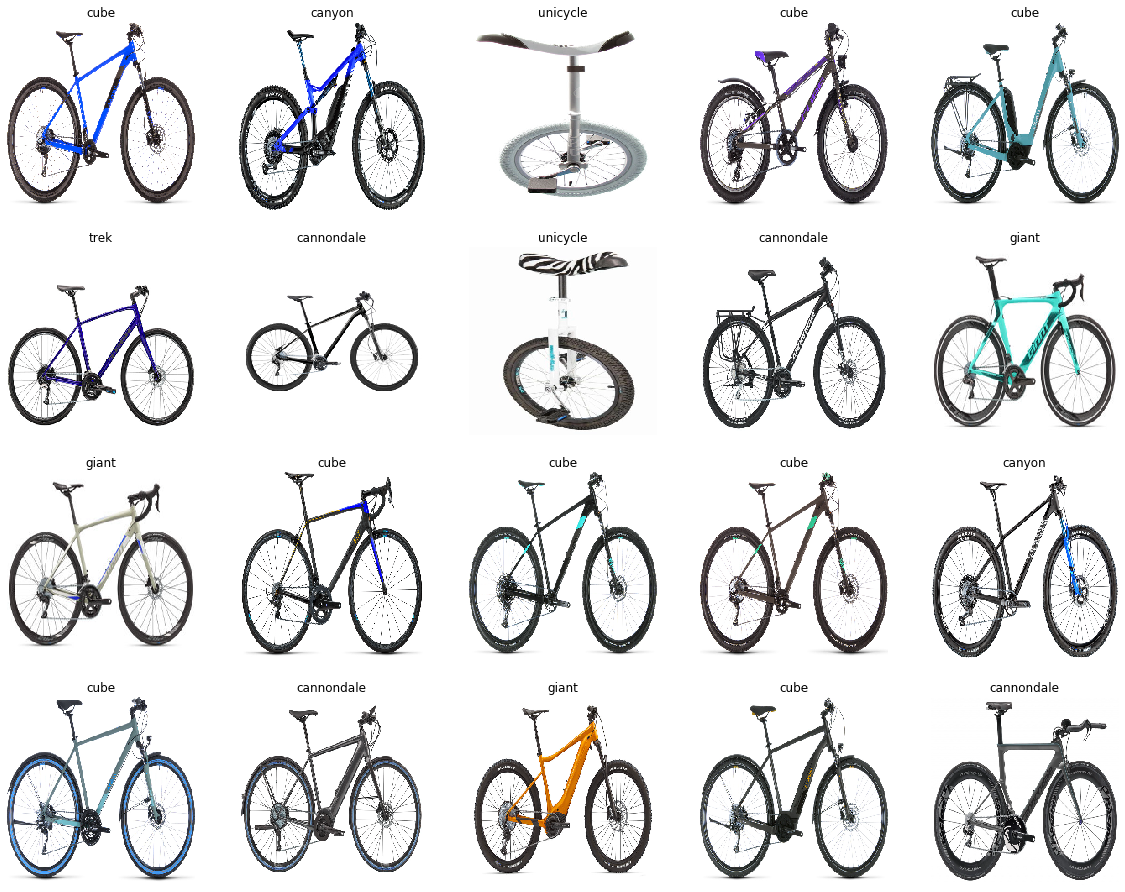

In [16]:
image_set = 2
ibatch = [img_batch[image_set]]
#images, rlabel_batch = val_it.get_next()#next(iter(test_ds))
predictions = model.predict(ibatch, steps=2)
#showBatch(timg_batch[0][:-50], None, predictions)
showBatch(img_batch[image_set], None, predictions)

In [ ]:
print (label_batch[image_set])
#for pred in predictions:
preds = list(np.argmax(pred) for pred in predictions)
print(preds)
for i in range(len(label_batch[image_set])):
    print(f'Real: {label_batch[image_set][i]} => Est: {preds[i]}, Value: {max(predictions[i])}')

In [ ]:
runtime = 10 # Laufzeit aus tf
maxAcc = 0.85 # Acc. aus tf
maxLoss = 0.2 # Loss aus tf

## Log